# Import all the relevant packages

In [18]:
import numpy as np
import pandas as pd
import datetime as dt
import sklearn
import lightgbm as lgb
import os
import csv
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import hyperopt
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import fmin
from hyperopt import Trials
import ast
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

os.chdir(r'C:\AnalyticsVidyaCompetitions\ML competition')

In [2]:
#import train and test data

raw_train=pd.read_csv('train.csv')

raw_test=pd.read_csv('test.csv')

In [8]:
# Getting profile report for train data

pandas_profiling.ProfileReport(raw_train)

In [9]:
# Getting profile report for test data

pandas_profiling.ProfileReport(raw_test)

In [3]:
print(raw_train.describe())
raw_train.head()

            loan_id  interest_rate  unpaid_principal_bal      loan_term  \
count  1.160580e+05  116058.000000          1.160580e+05  116058.000000   
mean   5.494155e+11       3.868961          2.082262e+05     292.280997   
std    2.597560e+11       0.461020          1.146851e+05      89.762415   
min    1.000010e+11       2.250000          1.100000e+04      60.000000   
25%    3.244655e+11       3.500000          1.200000e+05     180.000000   
50%    5.486240e+11       3.875000          1.830000e+05     360.000000   
75%    7.743035e+11       4.125000          2.780000e+05     360.000000   
max    9.999970e+11       6.750000          1.200000e+06     360.000000   

       loan_to_value  number_of_borrowers  debt_to_income_ratio  \
count  116058.000000        116058.000000         116058.000000   
mean       67.431939             1.593186             30.742293   
std        17.291719             0.491242              9.730798   
min         6.000000             1.000000              1

loan_id source       financial_institution  interest_rate  \
0  2.680550e+11      Z  Turner, Baldwin and Rhodes          4.250   
1  6.728320e+11      Y  Swanson, Newton and Miller          4.875   
2  7.425150e+11      Z              Thornton-Davis          3.250   
3  6.013860e+11      X                       OTHER          4.750   
4  2.738700e+11      X                       OTHER          4.750   

   unpaid_principal_bal  loan_term origination_date first_payment_date  \
0                214000        360         03/01/12             May-12   
1                144000        360         01/01/12             Mar-12   
2                366000        180         01/01/12             Mar-12   
3                135000        360         02/01/12             Apr-12   
4                124000        360         02/01/12             Apr-12   

   loan_to_value  number_of_borrowers  debt_to_income_ratio  \
0             95                    1                    22   
1             72                    1                    44   
2             49                    1                    33   
3             46                    2                    44   
4             80                    1                    43   

   borrower_credit_score loan_purpose  insurance_percent  \
0                    694          C86                 30   
1                    697          B12                  0   
2                    780          B12                  0   
3                    633          B12                  0   
4                    681          C86                  0   

   co-borrower_credit_score  insurance_type  m1  m2  m3  m4  m5  m6  m7  m8  \
0                         0               0   0   0   0   0   0   0   1   0   
1                         0               0   0   0   0   0   0   0   0   0   
2                         0               0   0   0   0   0   0   0   0   0   
3                       638               0   0   0   0   0   0   0   0   0   
4                         0               0   0   1   2   3   4   5   6   7   

   m9  m10  m11  m12  m13  
0   0    0    0    0    1  
1   0    0    1    0    1  
2   0    0    0    0    1  
3   1    1    1    1    1  
4   8    9   10   11    1

In [4]:
raw_test.describe()

loan_id  interest_rate  unpaid_principal_bal     loan_term  \
count  35866.000000   35866.000000          35866.000000  35866.000000   
mean   17933.500000       3.872850         207764.846930    293.130123   
std    10353.766714       0.460537         114561.745828     89.298799   
min        1.000000       2.375000          15000.000000     60.000000   
25%     8967.250000       3.500000         119000.000000    180.000000   
50%    17933.500000       3.875000         182000.000000    360.000000   
75%    26899.750000       4.125000         278000.000000    360.000000   
max    35866.000000       6.625000         802000.000000    360.000000   

       loan_to_value  number_of_borrowers  debt_to_income_ratio  \
count   35866.000000         35866.000000          35866.000000   
mean       67.388334             1.596805             30.762867   
std        17.246741             0.490546              9.726146   
min         5.000000             1.000000              1.000000   
25%        57.000000             1.000000             23.000000   
50%        72.000000             2.000000             31.000000   
75%        80.000000             2.000000             39.000000   
max        97.000000             2.000000             55.000000   

       borrower_credit_score  insurance_percent  co-borrower_credit_score  \
count           35866.000000       35866.000000              35866.000000   
mean              769.926504           2.729409                462.436681   
std                41.779664           8.029155                381.314899   
min                 0.000000           0.000000                  0.000000   
25%               751.000000           0.000000                  0.000000   
50%               782.000000           0.000000                742.000000   
75%               799.000000           0.000000                791.000000   
max               839.000000          35.000000                832.000000   

       insurance_type            m1            m2            m3            m4  \
count    35866.000000  35866.000000  35866.000000  35866.000000  35866.000000   
mean         0.003178      0.002844      0.002314      0.001952      0.002007   
std          0.056289      0.060600      0.058991      0.056838      0.059238   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          0.000000      0.000000      0.000000      0.000000      0.000000   
50%          0.000000      0.000000      0.000000      0.000000      0.000000   
75%          0.000000      0.000000      0.000000      0.000000      0.000000   
max          1.000000      3.000000      4.000000      5.000000      5.000000   

                 m5            m6            m7            m8            m9  \
count  35866.000000  35866.000000  35866.000000  35866.000000  35866.000000   
mean       0.002705      0.002370      0.003374      0.003680      0.004322   
std        0.071770      0.066958      0.086539      0.092898      0.099676   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        6.000000      6.000000      7.000000      5.000000      6.000000   

                m10           m11           m12  
count  35866.000000  35866.000000  35866.000000  
mean       0.005548      0.006162      0.007333  
std        0.121322      0.141455      0.160602  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max        7.000000      8.000000      9.000000

## Validating the categories between categorical variable in Train and Test sets

In [5]:
# test_fi=[raw_test.financial_institution.value_counts()]
# train_fi=[raw_train.financial_institution.value_counts()]

# print(train_fi)
# print(test_fi)

#Financial Instituition

print(set(pd.DataFrame(raw_train.financial_institution.value_counts()).reset_index(drop=False).iloc[:,0])-set(pd.DataFrame(raw_test.financial_institution.value_counts()).reset_index(drop=False).iloc[:,0]))

#Source

print(set(pd.DataFrame(raw_train.source.value_counts()).reset_index(drop=False).iloc[:,0])-set(pd.DataFrame(raw_test.source.value_counts()).reset_index(drop=False).iloc[:,0]))

#Loan purpose

print(set(pd.DataFrame(raw_train.loan_purpose.value_counts()).reset_index(drop=False).iloc[:,0])-set(pd.DataFrame(raw_test.loan_purpose.value_counts()).reset_index(drop=False).iloc[:,0]))

set()
set()
set()


## Creating buckets for variables like interest_rate and others

In [6]:
def clean_data(data):
    '''Creating function to clean dataset'''
    data['Interest_rate_bucket']=pd.cut(data.interest_rate,bins=[-1,3.5,4,100],labels=['low','medium','high'])
    data['Loan_term_bucket']=pd.cut(data.loan_term,bins=[-1,60,180,10000],labels=['low','medium','high'])
    data['LTV_bucket']=pd.cut(data.loan_to_value,bins=[-1,50,70,1000],labels=['low','medium','high'])
    data['DTI_bucket']=pd.cut(data.debt_to_income_ratio,bins=[-1,25,40,60,1000],labels=['very low','low','medium','high'])
    data['Insurance_bucket']=pd.cut(data.insurance_percent,bins=[-1,10,20,1000],labels=['low','medium','high'])
    data['LTV_bucket']=pd.cut(data.loan_to_value,bins=[0,50,70,1000],labels=['low','medium','high'])

    data['Average_score']=data.apply(lambda x: (x.borrower_credit_score+x['co-borrower_credit_score'])/2 if x['co-borrower_credit_score']>0 and x['number_of_borrowers']>1 else x['borrower_credit_score'],axis=1)

    data['Average_score_bucket']=pd.cut(data.Average_score,bins=[0,600,700,800,1000],labels=['very low','low','medium','high'])

    data['Risky']=data.apply(lambda x: 1 if x.m10+x.m11+x.m12>0 else 0,axis=1)

    data['Very_Risky']=data.apply(lambda x: 1 if x.m10+x.m11+x.m12>5 else 0,axis=1)
    
    data['Slightly_Risky']=data.apply(lambda x: 1 if x.m7+x.m8+x.m9+x.m10+x.m11+x.m12>0 else 0,axis=1)
    
    data.loan_purpose=data.loan_purpose.astype('category')
    
    data.source=data.source.astype('category')
    
    data.financial_institution=data.financial_institution.astype('category')
    
    return data

clean_train=clean_data(raw_train)
    
clean_train.head()

loan_id source       financial_institution  interest_rate  \
0  2.680550e+11      Z  Turner, Baldwin and Rhodes          4.250   
1  6.728320e+11      Y  Swanson, Newton and Miller          4.875   
2  7.425150e+11      Z              Thornton-Davis          3.250   
3  6.013860e+11      X                       OTHER          4.750   
4  2.738700e+11      X                       OTHER          4.750   

   unpaid_principal_bal  loan_term origination_date first_payment_date  \
0                214000        360         03/01/12             May-12   
1                144000        360         01/01/12             Mar-12   
2                366000        180         01/01/12             Mar-12   
3                135000        360         02/01/12             Apr-12   
4                124000        360         02/01/12             Apr-12   

   loan_to_value  number_of_borrowers  debt_to_income_ratio  \
0             95                    1                    22   
1             72                    1                    44   
2             49                    1                    33   
3             46                    2                    44   
4             80                    1                    43   

   borrower_credit_score loan_purpose  insurance_percent  \
0                    694          C86                 30   
1                    697          B12                  0   
2                    780          B12                  0   
3                    633          B12                  0   
4                    681          C86                  0   

   co-borrower_credit_score  insurance_type  m1  m2  m3  m4  m5  m6  m7  m8  \
0                         0               0   0   0   0   0   0   0   1   0   
1                         0               0   0   0   0   0   0   0   0   0   
2                         0               0   0   0   0   0   0   0   0   0   
3                       638               0   0   0   0   0   0   0   0   0   
4                         0               0   0   1   2   3   4   5   6   7   

   m9  m10  m11  m12  m13 Interest_rate_bucket Loan_term_bucket LTV_bucket  \
0   0    0    0    0    1                 high             high       high   
1   0    0    1    0    1                 high             high       high   
2   0    0    0    0    1                  low           medium        low   
3   1    1    1    1    1                 high             high        low   
4   8    9   10   11    1                 high             high       high   

  DTI_bucket Insurance_bucket  Average_score Average_score_bucket  Risky  \
0   very low             high          694.0                  low      0   
1     medium              low          697.0                  low      1   
2        low              low          780.0               medium      0   
3     medium              low          635.5                  low      1   
4     medium              low          681.0                  low      1   

   Very_Risky  Slightly_Risky  
0           0               1  
1           0               1  
2           0               0  
3           0               1  
4           1               1

In [7]:
# clean test set

clean_test=clean_data(raw_test)

clean_test.head()

loan_id source      financial_institution  interest_rate  \
0        1      Y              Browning-Hart          3.875   
1        2      X                      OTHER          4.500   
2        3      Y                      OTHER          4.500   
3        4      X  Miller, Mcclure and Allen          4.125   
4        5      X              Browning-Hart          3.250   

   unpaid_principal_bal  loan_term origination_date first_payment_date  \
0                417000        360         01/02/12             Apr-12   
1                113000        360         01/02/12             Apr-12   
2                 72000        360         01/01/12             Mar-12   
3                123000        180         01/02/12             Apr-12   
4                166000        180         01/02/12             Apr-12   

   loan_to_value  number_of_borrowers  debt_to_income_ratio  \
0             75                    1                    20   
1             80                    2                    33   
2             75                    1                    34   
3             41                    2                    24   
4             53                    2                    12   

   borrower_credit_score loan_purpose  insurance_percent  \
0                    790          A23                  0   
1                    793          C86                  0   
2                    710          C86                  0   
3                    798          A23                  0   
4                    767          A23                  0   

   co-borrower_credit_score  insurance_type  m1  m2  m3  m4  m5  m6  m7  m8  \
0                         0               0   0   0   0   0   0   0   0   0   
1                       784               0   0   0   0   0   0   0   0   0   
2                         0               0   0   0   0   0   0   0   0   0   
3                       813               0   0   0   0   0   0   0   0   0   
4                       768               0   0   0   0   0   0   0   0   0   

   m9  m10  m11  m12 Interest_rate_bucket Loan_term_bucket LTV_bucket  \
0   0    0    0    0               medium             high       high   
1   0    0    0    0                 high             high       high   
2   0    0    0    0                 high             high       high   
3   0    0    0    0                 high           medium        low   
4   0    0    0    0                  low           medium     medium   

  DTI_bucket Insurance_bucket  Average_score Average_score_bucket  Risky  \
0   very low              low          790.0               medium      0   
1        low              low          788.5               medium      0   
2        low              low          710.0               medium      0   
3   very low              low          805.5                 high      0   
4   very low              low          767.5               medium      0   

   Very_Risky  Slightly_Risky  
0           0               0  
1           0               0  
2           0               0  
3           0               0  
4           0               0

In [8]:
clean_train.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'Interest_rate_bucket', 'Loan_term_bucket', 'LTV_bucket',
       'DTI_bucket', 'Insurance_bucket', 'Average_score',
       'Average_score_bucket', 'Risky', 'Very_Risky', 'Slightly_Risky'],
      dtype='object')

### Create train and test sets

In [33]:
#columns to be used for training

cols=[
#     'loan_id', 'interest_rate','Average_score','financial_institution','origination_date','first_payment_date',
    'unpaid_principal_bal', 'loan_term',  'loan_to_value',
       'debt_to_income_ratio', 'borrower_credit_score', 'insurance_percent', 'co-borrower_credit_score',
      'm1','m2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
      'loan_purpose','source', 'number_of_borrowers','insurance_type', 
       'Interest_rate_bucket', 'Loan_term_bucket', 'LTV_bucket',
       'DTI_bucket', 'Insurance_bucket', 
       'Average_score_bucket', 'Risky', 'Very_Risky', 'Slightly_Risky']

x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(clean_train[cols],clean_train.m13,test_size=0.2)

features,test_features=x_train,x_test
train_labels,test_labels=y_train,y_test

print('Train set shape is %s, test set shape is %s',str(features.shape),str(test_features.shape))

train_set=lgb.Dataset(features,label=train_labels)

Train set shape is %s, test set shape is %s (92846, 32) (23212, 32)


In [34]:
features[:10]

unpaid_principal_bal  loan_term  loan_to_value  debt_to_income_ratio  \
6137                  300000        180             69                    16   
109131                304000        360             57                    21   
110321                 88000        180             80                    33   
77035                 200000        360             80                    29   
64863                 365000        360             40                    31   
25812                  46000        180             31                    18   
81697                 216000        360             80                    26   
11887                 159000        360             55                    40   
58373                 150000        180             52                    31   
6768                   95000        360             95                    31   

        borrower_credit_score  insurance_percent  co-borrower_credit_score  \
6137                      795                  0                       806   
109131                    778                  0                       778   
110321                    660                  0                       749   
77035                     792                  0                       785   
64863                     800                  0                       794   
25812                     800                  0                       800   
81697                     813                  0                       797   
11887                     744                  0                       663   
58373                     734                  0                       694   
6768                      746                 30                       746   

        m1  m2  m3  m4  m5  m6  m7  m8  m9  m10  m11  m12 loan_purpose source  \
6137     0   0   0   0   0   0   0   0   0    0    0    0          B12      X   
109131   0   0   0   0   0   0   0   0   0    0    0    0          B12      X   
110321   0   0   0   0   0   0   0   0   0    0    0    0          B12      X   
77035    0   0   0   0   0   0   0   0   0    0    0    0          A23      Z   
64863    0   0   0   0   0   0   0   0   0    0    0    0          B12      Z   
25812    0   0   0   0   0   0   0   0   0    0    0    0          A23      Y   
81697    0   0   0   0   0   0   0   0   0    0    0    0          C86      X   
11887    0   0   0   0   0   0   0   0   0    0    0    0          B12      Y   
58373    0   0   0   0   0   0   0   0   0    0    0    0          B12      X   
6768     0   0   0   0   0   0   0   0   0    0    0    0          A23      Y   

        number_of_borrowers  insurance_type Interest_rate_bucket  \
6137                      2               0                  low   
109131                    2               0               medium   
110321                    2               0               medium   
77035                     2               0               medium   
64863                     2               0               medium   
25812                     2               0                  low   
81697                     2               0               medium   
11887                     2               0                 high   
58373                     2               0                  low   
6768                      2               0               medium   

       Loan_term_bucket LTV_bucket DTI_bucket Insurance_bucket  \
6137             medium     medium   very low              low   
109131             high     medium   very low              low   
110321           medium       high        low              low   
77035              high       high        low              low   
64863              high        low        low              low   
25812            medium        low   very low              low   
81697              high       high        low              low   
11887              high     medium        low              low   
58373            medium     mediu

### Creating objective function for Bayesian optimization

In [35]:
evals=50
n_folds=5

# Hyper-parameter grid

param_grid = {
    'class_weight': hp.choice('class_weight', [None]),
    'is_unbalance':hp.choice('is_unbalance',[True]),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 2, 100, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.1), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 10, 3000, 20),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

def objective(params,n_folds=n_folds):
    global iteration
    iteration+=1
    subsample=params['boosting_type'].get('subsample',1.0)
    params['boosting_type']=params['boosting_type']['boosting_type']
    params['subsample']=subsample
    for parameter in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter]=int(params[parameter])
    start=timer()
    cv_results=lgb.cv(params,train_set,num_boost_round=100,nfold=n_folds,early_stopping_rounds=100,metrics='auc',seed=50)
    cv_time=timer()-start
    score=np.max(cv_results['auc-mean'])
    loss=1-score
    trees=int(np.argmax(cv_results['auc-mean'])+1)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, iteration, trees, cv_time])
    return {'loss': loss, 'params': params, 'iteration': iteration,'estimators': trees, 'train_time': cv_time, 'status': STATUS_OK}

tpe_algorithm = tpe.suggest

bayes_trials = Trials()

out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'trees', 'train_time'])
of_connection.close()

global  iteration

iteration = 0

# Run optimization
best = fmin(fn = objective, space = param_grid, algo = tpe.suggest, 
            max_evals = evals, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 50/50 [12:34<00:00, 15.09s/it, best loss: 0.10593474910184209]


### Getting the results from the saved csv file

In [36]:
results_theory=sorted(bayes_trials.results,key=lambda x: x['loss'])

results=pd.read_csv('gbm_trials.csv')

results.sort_values('loss',ascending=True,inplace=True)

results.reset_index(drop=True,inplace=True)

### running the model on the optimal parameters

In [37]:
import ast 

optimal_trees=int(results.loc[0,'trees'])

optimal_params=ast.literal_eval(results.loc[0, 'params']).copy()

final_model=lgb.LGBMClassifier(n_estimators=optimal_trees,objective='binary',**optimal_params)

final_model.fit(clean_train[cols],clean_train.m13)

LGBMClassifier(boosting_type='dart', class_weight=None,
               colsample_bytree=0.7379495634322363, importance_type='split',
               is_unbalance=True, learning_rate=0.3215584289779793,
               max_depth=-1, min_child_samples=220, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=12, n_jobs=-1, num_leaves=7,
               objective='binary', random_state=None,
               reg_alpha=0.9403029389562794, reg_lambda=0.49779820645222617,
               silent=True, subsample=0.6719656640928834,
               subsample_for_bin=280000, subsample_freq=0)

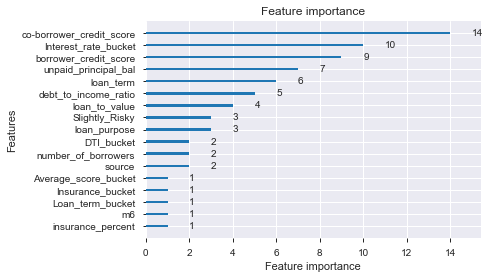

In [38]:
lgb.plot_importance(final_model)

In [39]:
preds=final_model.predict_proba(clean_test[cols])[:,1]

pd.DataFrame(preds).to_csv('Output of gbm.csv')